# **Coursework 2** 

**Miguel de Llanza Varona**

Candiate Number: **234717**

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import math
from random import expovariate # Generate variates from exponential distribution

# Analytical Work

**Question 3**

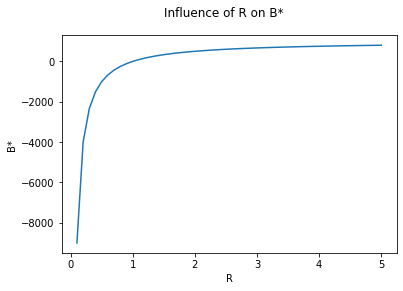

In [3]:
N = 1000
R = np.linspace(0.1,5)

# Compute the B star formula found in the analytical part using different R values
B_star = [N - (N / R[x]) for x in range(len(R))]

# Plot results
plt.plot(R, B_star)
plt.xlabel('R')
plt.ylabel('B*')
plt.suptitle('Influence of R on B*')
plt.show()

As expected, the system is stable when $R_0 < 1$, which is indicated by the negative values. Of course, the value of $[B]$ can't be negative, but it illustrates how the population will converge to $N=A$, which means that $B=0$. On the other hand, when $R_0>1$, the system grows above zero, which is a sign of its unstability. Finally, when $R_0=1$, $B^*=0$. 

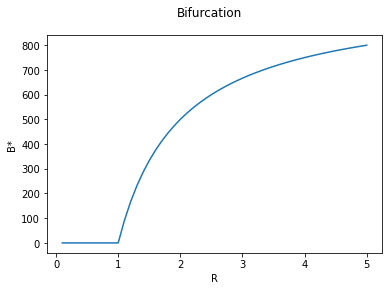

In [4]:
N = 1000
R = np.linspace(0.1,5)
B_star = []
R_new = []
# Compute the B star formula found in the analytical part using different R values
# and setting the negative values to zero
for x in range(len(R)):
  if N - (N / R[x]) < 0:
    B_star.append(0)
    R_new.append(R[x])
  else:
    B_star.append(N - (N / R[x]))
    R_new.append(R[x])


# Plot results
plt.plot(R_new, B_star)
plt.xlabel('R')
plt.ylabel('B*')
plt.suptitle('Bifurcation')
plt.show()

**Question 5**

In [5]:
def b_star_equation(N, b0, beta, gamma, t):
  b_star = ((beta * N - N * gamma) / beta)
  return (b_star / ((b_star / b0 - 1) * math.e**((gamma - beta) * t) + 1))

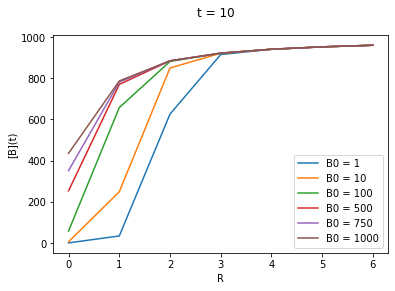

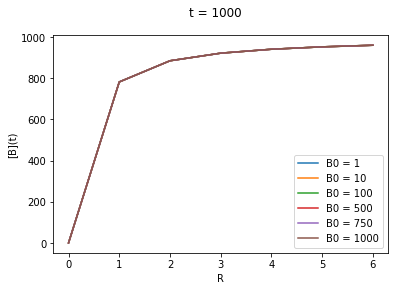

In [6]:
N = 1000
B0 = [1, 10, 100, 500, 750, 1000]
beta = np.linspace(0.05, 2.5, 7)
gamma = 0.1

R = [beta[ind] / gamma for ind in range(len(beta))]

for i in range(len(B0)):
  bt1,bt2 = [],[]
  for j in range(len(beta)):
    try:
      b_0 = b_star_equation(N, B0[i], beta[j], gamma, 10)
      b_1 = b_star_equation(N, B0[i], beta[j], gamma, 1000)
    except:
      b_0 = 0
      b_1 = 0
    bt1.append(b_0)
    bt2.append(b_1)
     
  # Plots for each time chosen
  plt.figure(1)
  plt.xlabel('R')
  plt.ylabel('[B](t)')
  plt.suptitle('t = 10')
  plt.plot(bt1, label='B0 = ' + str(B0[i]))
  plt.legend(loc='best')
  plt.figure(2)
  plt.suptitle('t = 1000')
  plt.plot(bt2, label='B0 = ' + str(B0[i]))
    
plt.legend(loc='best')
plt.xlabel('R')
plt.ylabel('[B](t)')
plt.show()

As can be seen, the system is at a stable equilibrium when $[B] = 0$ and $B_0=0$. For both cases ($t=10$ and $t=1000$), in all initial populations $B_0$ there is convergence towards $B^*$ when the time is large enough.

In [7]:
def mean_field(B, N, beta, gamma):
  return (beta * B / N) * (N - B) - gamma * B

In [10]:
def euler_method(N, b0, beta, gamma, t_max, dt):
  """
  Euler method for integration
  """
  t = 0
  B0 = [b0]
  ts = [t]
  
  while t <= t_max:
    b0 = max(b0 + dt * mean_field(b0, N, beta, gamma), 0)

    B0.append(b0)

    t += dt
    ts.append(t)
      
  return B0, b0, ts

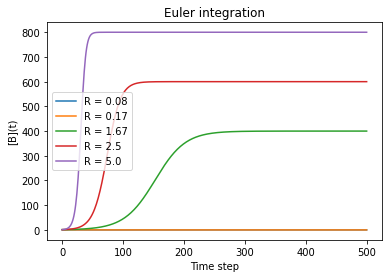

In [22]:
N = 1000
b0 = 1
betas = [0.05, 0.1, 1, 1.5, 3]
gamma = 0.6
t_max = 50
dt = 0.1

for beta in betas:
  R = beta / gamma
  B0, b, times = euler_method(N, b0, beta, gamma, t_max, dt)
  plt.plot(B0, label='R = ' + str(np.round(R, 2)))
  plt.title('Euler integration')

plt.legend(loc='best')
plt.xlabel('Time step')
plt.ylabel('[B](t)')
plt.show()

The plot above shows the results fro the Euler integration method. As can be seen, the value of $B(t)$ changes as a function of $R_0$. In particular, when $R_0 < 1$ the value of $B(t)$ tends to a zero equilibrium 0. When $R_0>1$, the system converges to a non-zero equilibrium.


# Simulation Work

In [24]:
def gillespie_ABA(N,B0,beta,gamma,Tmax):

  A = [N - B0] # We cannot predict how many elements there will be unfortunately
  B = [B0]
  T = [0] 
  state = np.random.permutation([0] * (N - B0) + [1] * B0) # Randomly allocate B0 individuals to have state B (state=1), A (state=0) otherwise 
  B_contacts = np.where(state==1)[0] # Index of individuals in state B (state=1).
  rate_vector = B0 * beta * np.ones((N,1)) / N # Set rates to be B0*beta/N (rate for individuals in state A) to all individuals (initialisation). 
  rate_vector[B_contacts] = gamma # Update rate of B_contacts to be gamma (the rate for individuals in state B)
  
  time = 0
  while time <= Tmax + 0.5: # some (arbitrary) buffer after Tmax
    rate = np.sum(rate_vector) # Total rate (refer to Gillespie algorithm for details)
    cumrate = np.cumsum(rate_vector) # Cumulated sum of rates
    if rate > 0.000001: # if rate is sufficiently large
      tstep = expovariate(rate) # Pick an exponentially distributed time. Beware of difference with exprnd in Matlab where it is 1/rate
      T.append(T[-1] + tstep) # Time of next event
      event = np.where(cumrate > np.random.rand() * rate)[0][0] # Find which individual will see its state change 
      if state[event] == 0: # individual is in state A 
        A.append(A[-1] - 1) # this state A individual becomes state B so number of state A individuals is decreased
        B.append(B[-1] + 1) # obviously, number of state B individuals is increased 
        state[event] = 1 # Update state vector
        rate_vector[event] = gamma # Change rate of individual to B->A rate, namely gamma
        A_contacts = np.where(state == 0)[0] # List of state A individuals after change
        rate_vector[A_contacts] += beta / N # Update rate of state A individuals to account for the extra state B individual
      else: # individual is in state B
        B.append(B[-1] - 1) # this state B individual becomes state A so number of state B individuals is decreased
        A.append(A[-1] + 1) # obviously, number of state A individuals is increased
        state[event] = 0 # Update state vector
        A_contacts = np.where(state == 0)[0] # List of state A individuals after changes                                
        rate_vector[A_contacts] = beta * len(np.where(state == 1)[0]) / N # Update rate of state A individuals based on number of B individuals  
    else: # Nothing will happen from now on so we can accelerate the process
      time = T[-1] # current time
      while time <= Tmax + 0.5:
        A.append(A[-1]) # Just keep things as they are
        B.append(B[-1])
        T.append(T[-1] + 0.5) # arbitrarily add 0.5 to clock
        time = T[-1]
    # Update time and proceed with loop 
    time = T[-1]         

  return T,A,B    

**Question 1**

In order to study the impact of each of the parameters on the B population using the Gillespie algortihm proveided, I have modified only one of the parameters while the others have been remained constant. By doing this, it can be studied the role that each parameter, in isolation, might have on the behviour of the population B. To visualize each case, I have plotted the results.


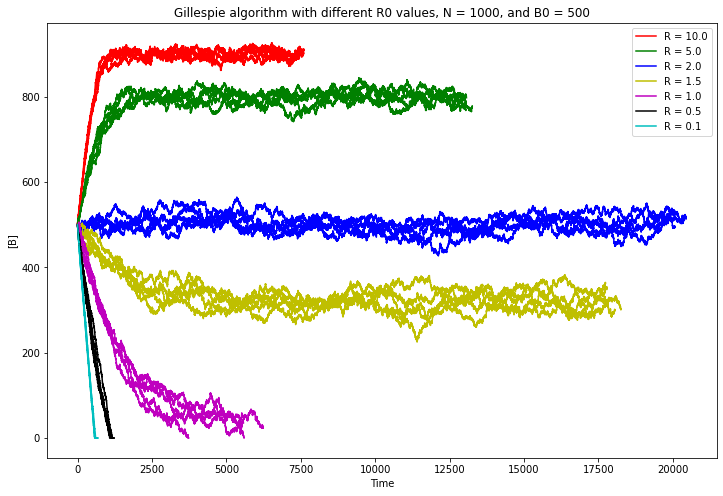

In [33]:
N = 1000
B0 = 500
beta = [1]*9
gamma = [0.1, 0.2, 0.5, 2/3, 1, 2, 10]
t_max = 40
repetitions = 5
colors = ['r', 'g', 'b', 'y', 'm', 'k', 'c']

plt.figure(figsize=(12,8))
for rep in range(repetitions):
  for i,g in enumerate(gamma):

    B = gillespie_ABA(N, B0, beta[i], g, t_max)[2]
    if rep == 0:
      plt.plot(B, colors[i], label='R = ' + str(np.round(beta[i] / g, 2)))
    else:
      plt.plot(B, colors[i])

plt.title('Gillespie algorithm with different R0 values, N = ' + str(N) + ', and B0 = ' + str(B0))
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('[B]')
plt.show()

In the first case, I have studied the influence that $R_0$ has on $[B]$. To do that, I have used a range of values for $R_0$ (from $0.1$ to $10$), and the rest of the parameters have been kept constant ($N=1000$ and $B_0=500$). 

By looking at the plot above it can be observed the behaviour predicted in the analytical part; namely, that the stability of the system depends on whether $R_0$ is bigger or lower than $1$. In particular, as stated in the analytical part, after calculating $B^*$, it was found that if $R_0>1$ there is stability and, on the contrary, when $R_0 < 1$, part, inestability is found. 

For all $R_0$ such that $R_0>1$, the $B$ population tends to some fixed point, despite of the variation obtained due to the stochasticity of the process. Let's exemplified this by computing $B^*$ for $R_0=10$:

$$ B^* = 1000 - \frac{1000}{10} = 900 $$ 

which is, approximately, what it is shown in the plot above.

However, when $R_0 < 1$, the behaviour of the system is unstable. As illustrated in the plot, the different realisations undergo an exponential decay, as it is the rate of change of the population is a function of the actual population. When $[B] = 0$ is reached, there is stability since it is the other equilibrium previously obtained. 

Finally, when $R_0=1$, there is a center manifold and, consequently, the stability for that fixed point is uncertain; higher derivatives are needed in order to reach some conclusion. 

--------------------------------------------------------------------------------

Now, I will examine how the systems changes as the initial B population ($B_0$) varies. 

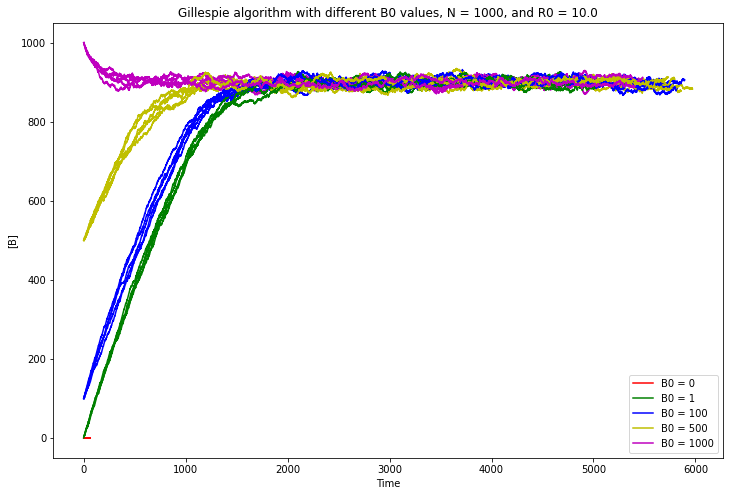

In [34]:
N = 1000
Bs = [0, 1, 100, 500, 1000]
beta = 1
gamma = 0.1
t_max = 30
repetitions = 5
colors = ['r', 'g', 'b', 'y', 'm', 'c']

plt.figure(figsize=(12,8))
for rep in range(repetitions):
  for i,B0 in enumerate(Bs):

    B = gillespie_ABA(N, B0, beta, gamma, t_max)[2]
    # Plot B and only label in the first repetition
    if rep == 0:
      plt.plot(B, colors[i], label='B0 = ' + str(B0))
    else:
      plt.plot(B, colors[i])

plt.title('Gillespie algorithm with different B0 values, N = ' + str(N) + ', and R0 = ' + str(beta/gamma))
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('[B]')
plt.show()

What the plot above shows is that almost all initial populations $B_0$ converge to an stable point determined by the $B^*$ equilibrium which, taking as constants $N=1000$ and $R_0=10$, corresponds to $900$ (as calculated before). 

However, since there is another stable point when $B_0=0$ and the process is stochastic, there is some chance that some of the realisations of nearer initial populations such as $B_0=1$ will converge to the zero equilibrium $B_0=0$, instead of the non-zero equilibrium $B^*=900$.

--------------------------------------------------------------------

Finally, I have studied how the total population $N$ affects $[B]$. To do that, I have kept constant $R_0$ and each initial population is always set to half of the total population (i.e., $\frac{N}{2}$).

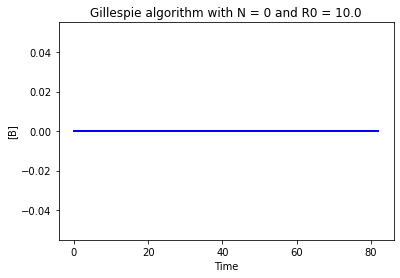

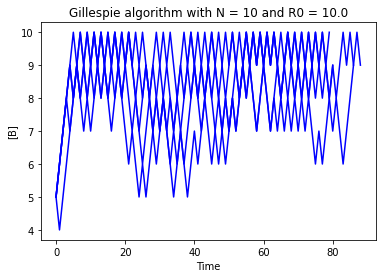

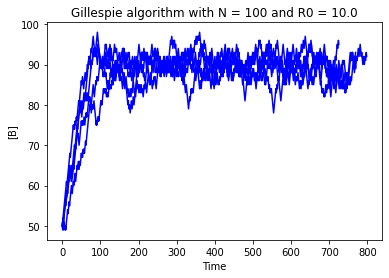

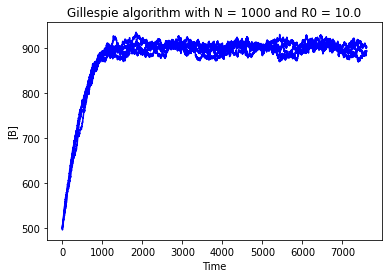

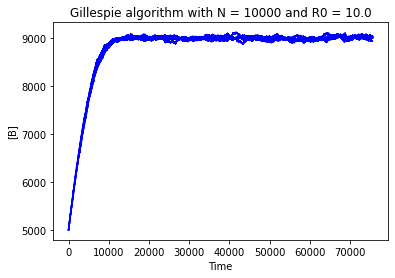

In [35]:
Ns = [0, 10, 100, 1000, 10000]
beta = 1
gamma = 0.1
t_max = 40
repetitions = 5
colors = ['r', 'g', 'b', 'y', 'm']

for i,N in enumerate(Ns):
  for rep in range(repetitions):
    B = gillespie_ABA(N, N//2, beta, gamma, t_max)[2]
    # Plot B
    plt.plot(B, 'b')
  
  plt.title('Gillespie algorithm with N = ' + str(N) + ' and R0 = ' + str(beta/gamma))
  plt.xlabel('Time')
  plt.ylabel('[B]')
  plt.show()

In the simplest case, when $N=0$, $[B]$ is always zero, as expected. 

$$\dot{[B]} = \beta \frac{[B]}{N}[A]-\gamma[B]$$

According to the formula, the right part of the equation ($-\gamma[B]$) is always constant, since it does not depend on $N$. As $N$ gets higher, the left part of the equation ($\beta \frac{[B]}{N}[A]$) tends to zero and, thus, does not affect the final result. This explains why, as $N$ gets bigger, the plots show a more defined behaviour that exhibits a lot less variance. It is in these cases (large $N$), where the exponential decay, which is a consequence of the right part of the equation ($-\gamma[B]$ ), can be clearly seen. On the contray, in the initial plots, since $N$ is smaller, the initial decay can be bearly seen and the result is more noisy. 

**Question 2**

In [36]:
def mean_std(lists):
  """
  Compute mean and standard devaition of the elements of a list that are
  non-masked when the length of the input lists are not equal
  """
  list_lens = [len(l) for l in lists]
  arr = np.ma.empty((np.max(list_lens),len(lists)))
  arr.mask = True
  for ind, l in enumerate(lists):
      arr[:len(l),ind] = l
  return arr.mean(axis=-1), arr.std(axis=-1)

In this part, I use the same plots as above to add the mean and standard deviation of every set of realisations corresponding to each initial condition. 

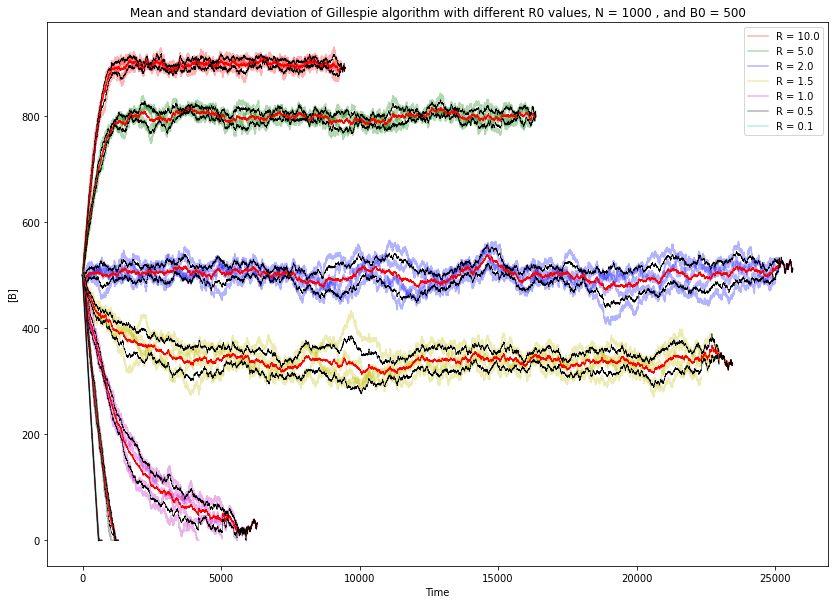

In [37]:
N = 1000
B0 = 500
beta = [1]*7
gamma = [0.1, 0.2, 0.5, 2/3, 1, 2, 10]
t_max = 50
repetitions = 5
colors = ['r', 'g', 'b', 'y', 'm', 'k', 'c']
plt.figure(figsize=(14,10))

for i,g in enumerate(gamma):
  Bs = []
  for rep in range(repetitions):

    B = gillespie_ABA(N, B0, beta[i], g, t_max)[2]
    Bs.append(B)
    # Plot B and only label in the first repetition
    if rep == 0:
      plt.plot(B, colors[i], label='R = ' + str(np.round(beta[i] / g, 2)), alpha=0.3)
    else:
      plt.plot(B, colors[i], alpha=0.3)

  # Obtain mean and standard deviation
  mean, std = mean_std(Bs)
  # Plot mean and standard deviation
  plt.plot(np.arange(len(mean))+1, mean, 'r', linewidth=1)
  plt.plot(mean + std, 'k', linewidth=0.5)
  plt.plot(mean - std, 'k', linewidth=0.5)
 
plt.title('Mean and standard deviation of Gillespie algorithm with different R0 values, N = ' + str(N) + ' , and B0 = ' + str(B0))
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('[B]')
plt.show()

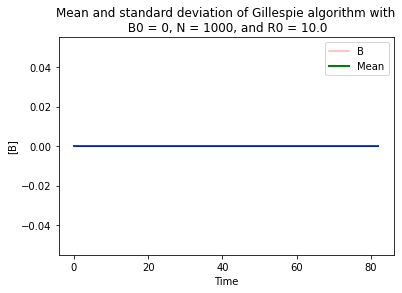

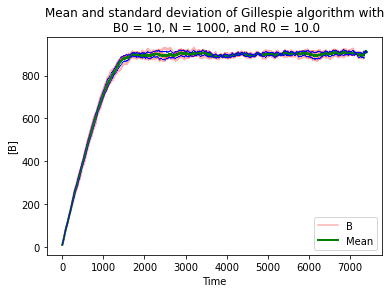

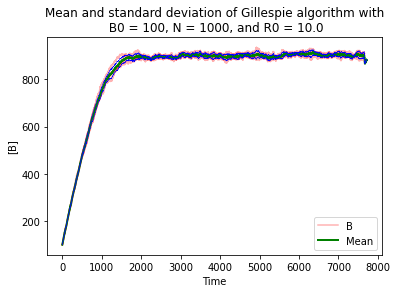

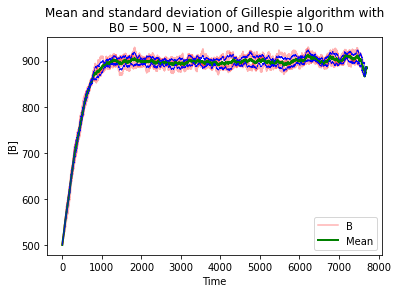

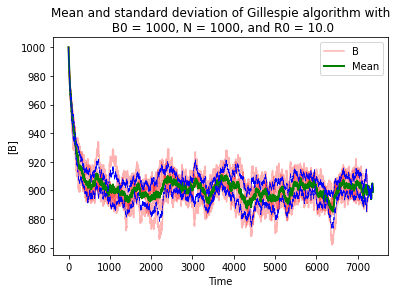

In [38]:
N = 1000
Bs = [0, 10, 100, 500, 1000]
beta = 1
gamma = 0.1
t_max = 40
repetitions = 5

for i,B0 in enumerate(Bs):
  B_s = []
  for rep in range(repetitions):  

    B = gillespie_ABA(N, B0, beta, gamma, t_max)[2]
    B_s.append(B)
    # Plot B and only label in the first repetition
    if rep == 0:
      plt.plot(B, 'r', label='B', alpha=0.3)
    else:
      plt.plot(B, 'r', alpha=0.3)

  # Obtain mean and standard deviation
  mean, std = mean_std(B_s)
  # Plot mean and standard deviation
  plt.plot(np.arange(len(mean)), mean, 'g', label='Mean', linewidth=2)
  plt.plot(mean + std, 'b', linewidth=0.5)
  plt.plot(mean - std, 'b', linewidth=0.5)

  plt.title('Mean and standard deviation of Gillespie algorithm with\n B0 = ' + str(B0) + ', N = ' + str(N) + ', and R0 = ' + str(beta/gamma))
  plt.xlabel('Time')
  plt.ylabel('[B]')
  plt.legend(loc='best')
  plt.show()

As can be seen in these plots, as the initial population ($[B]$) gets bigger, the variance increases (standard deviation is bigger). On the contrary, with smaller $[B]$, the standard deviation gets closer to the mean of all realisations. 

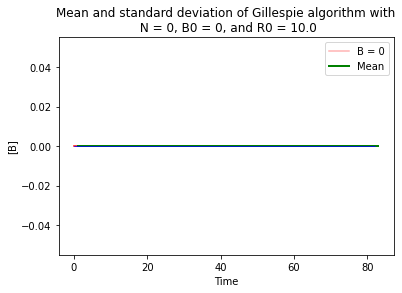

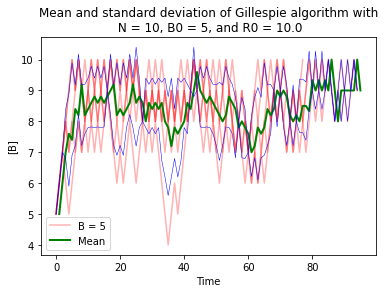

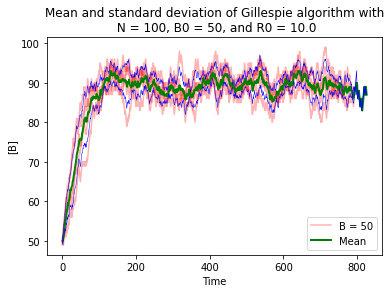

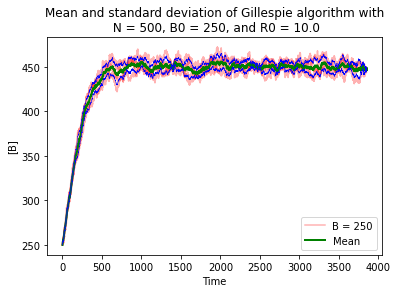

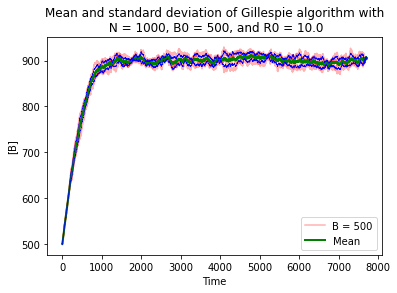

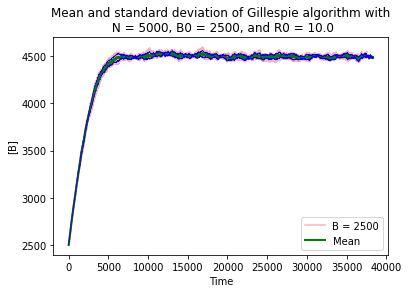

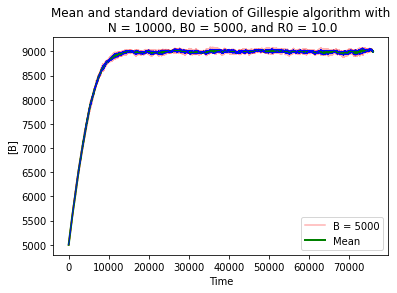

In [39]:
Ns = [0, 10, 100, 500, 1000, 5000, 10000]
beta = 1
gamma = 0.1
t_max = 40
repetitions = 5
colors = ['r', 'g', 'b', 'y', 'm']

for i,N in enumerate(Ns):
  Bs = []
  for rep in range(repetitions):
    B = gillespie_ABA(N, N//2, beta, gamma, t_max)[2]
    Bs.append(B)
    # Plot B and only label in the first repetition
    if rep == 0:
      plt.plot(B, 'r', label='B = ' + str(N//2), alpha=0.3)
    else:
      plt.plot(B, 'r', alpha=0.3)
  
  # Obtain mean and standard deviation
  mean, std = mean_std(Bs)
  # Plot mean and standard deviation
  plt.plot(np.arange(len(mean))+1, mean, 'g', linewidth=2, label='Mean')
  plt.plot(mean + std, 'b', linewidth=0.5)
  plt.plot(mean - std, 'b', linewidth=0.5)
  
  # for x,y,z,t,u in zip(*Bs):
  #   mean.append(np.mean([x,y,z,t,u]))
  #   std.append(np.std([x,y,z,t,u]))
  # means = np.array(mean)
  # stds = np.array(std)
  # plt.plot(means, 'b', linewidth = 2)
  # plt.plot(means + stds, 'k-', linewidth = 1)
  # plt.plot(means - stds, 'k-', linewidth = 1)

  plt.title('Mean and standard deviation of Gillespie algorithm with\n N = ' + str(N) + ', B0 = ' + str(N//2) + ', and R0 = ' + str(beta/gamma))
  plt.xlabel('Time')
  plt.ylabel('[B]')
  plt.legend(loc='best')
  plt.show()

Now, as the population $N$ increases, the standard deviation gets smaller; all different realisations tend to take values that are very similar to each other; the results seems much less noisy as $N$ increases. 

**Question 3**

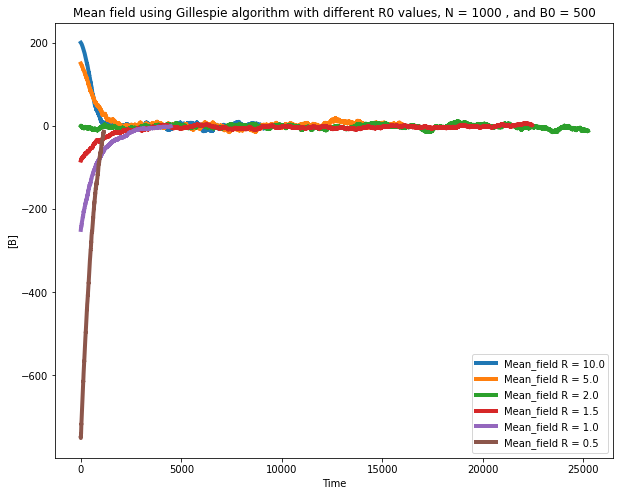

In [40]:
N = 1000
B0 = 500
beta = [1]*7
gamma = [0.1, 0.2, 0.5, 2/3, 1, 2]
t_max = 50
repetitions = 5
colors = ['r', 'g', 'b', 'y', 'm', 'k', 'c']
plt.figure(figsize=(10,8))

for i,g in enumerate(gamma):
  Bs = []
  mf = []
  for rep in range(repetitions):

    B = gillespie_ABA(N,B0,beta[i],g,t_max)[2]
    Bs.append(B)
  # Obtain mean
  mean = [np.mean([x,y,z,t,u]) for x,y,z,t,u in zip(*Bs)]

  for m in mean:
    # Obtain mean field
    mf.append(mean_field(m,N,beta[i],g))
  # Plot mean field
  plt.plot(mf, linewidth = 4, label='Mean_field R = ' + str(np.round(beta[i] / g, 2)))

plt.title('Mean field using Gillespie algorithm with different R0 values, N = ' + str(N) + ' , and B0 = ' + str(B0))
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('[B]')
plt.show()

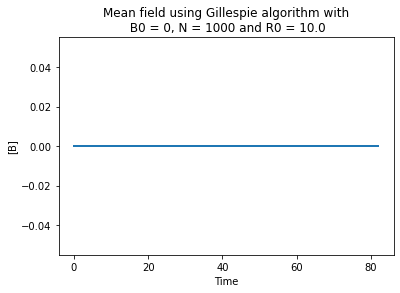

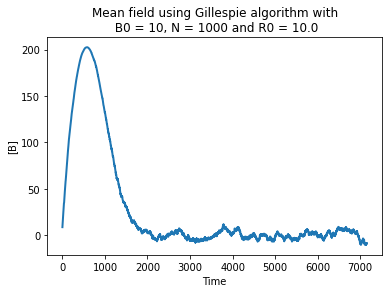

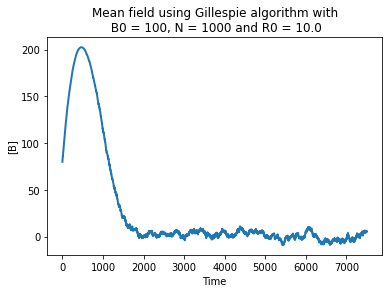

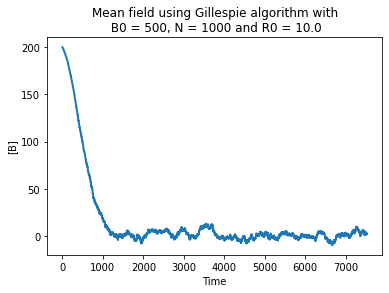

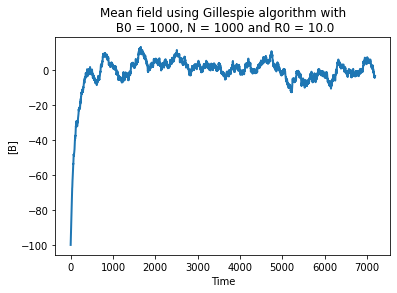

In [41]:
N = 1000
Bs = [0, 10, 100, 500, 1000]
beta = 1
gamma = 0.1
t_max = 40
repetitions = 5
colors = ['r', 'g', 'b', 'y', 'm']

for i,B0 in enumerate(Bs):
  B_s = []
  mf = []
  for rep in range(repetitions):  

    B = gillespie_ABA(N, B0, beta, gamma, t_max)[2]
    B_s.append(B)
  # Obtian mean
  mean = [np.mean([x,y,z,t,u]) for x,y,z,t,u in zip(*B_s)]

  for m in mean:
    # Obtain mean field
    mf.append(mean_field(m,N,beta,gamma))
  # Plot mean field
  plt.plot(mf, linewidth = 2)
  plt.title('Mean field using Gillespie algorithm with\n B0 = ' + str(B0) + ', N = ' + str(N) + ' and R0 = ' + str(beta/gamma))
  plt.xlabel('Time')
  plt.ylabel('[B]')
  plt.show()

By computing the mean field equation it is obtained the gradient at each point. Thaçt is why when B reaches an equilibrium, the rate of changes stabilizes and remains approximately constant (there is always some noisy due to the stochasticity of the process). Therefore, the mean field for each case tends to 0, as the rate of change is zero when B is in equilibrium. Note that, depending on the $R_0$ value and the initial population, the equilibrium  might not be reached, and thus, the mean field equation might not converge to zero in those cases. The main difference between each plot is the initial exponential drop; the firsts values are positive or negative depending on the initial B population ($B_0). 

**Question 4**

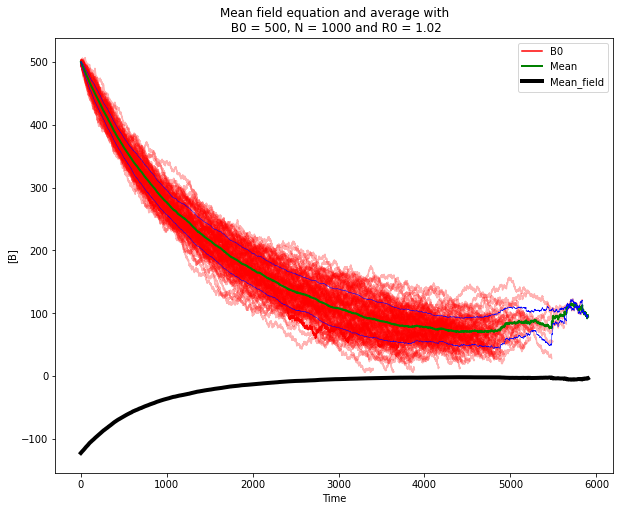

In [43]:
N = 1000
B0 = 500
beta = 0.51
gamma = 0.5
t_max = 40
repetitions = 100
plt.figure(figsize=(10,8))

Bs = []
for rep in range(repetitions):  

  B = gillespie_ABA(N, B0, beta, gamma, t_max)[2]
  Bs.append(B)
  # Plot B and only label in the first repetition
  if rep == 0:
    plt.plot(B, 'r', label='B0')
  else:
    plt.plot(B, 'r', alpha=0.3)
  
# Obtain mean and standard deviation
mean, std = mean_std(Bs)
# Plot mean and standard deviation
plt.plot(np.arange(len(mean))+1, mean, 'g', linewidth=2, label='Mean')
plt.plot(mean + std, 'b', linewidth=0.5)
plt.plot(mean - std, 'b', linewidth=0.5)

# Obtain mean field
mf = [mean_field(m,N,beta,gamma) for m in mean]
# Plot mean field
plt.plot(mf, 'k', label='Mean_field', linewidth=4)
plt.title('Mean field equation and average with\n B0 = ' + str(B0) + ', N = ' + str(N) + ' and R0 = ' + str(beta/gamma))
plt.xlabel('Time')
plt.ylabel('[B]')
plt.legend(loc='best')
plt.show()

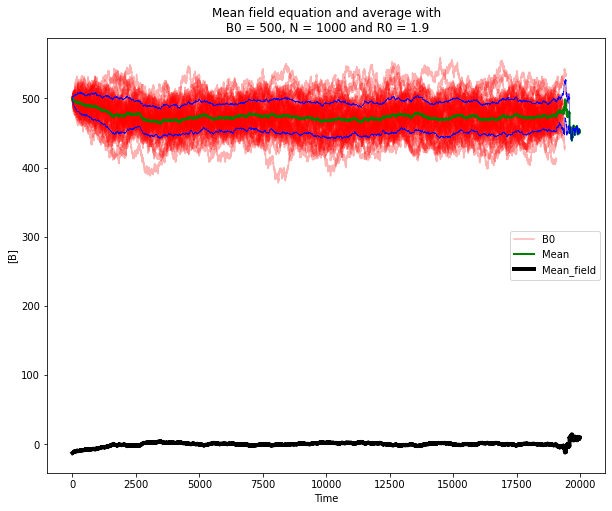

In [44]:
N = 1000
B0 = 500
beta = 0.95
gamma = 0.5
t_max = 40
repetitions = 50
plt.figure(figsize=(10,8))
Bs = []

for rep in range(repetitions):  

  B = gillespie_ABA(N, B0, beta, gamma, t_max)[2]
  Bs.append(B)
  # Plot and only label in the first repetition
  if rep == 0:
    plt.plot(B, 'r', label='B0', alpha=0.3)
  else:
    plt.plot(B, 'r', alpha=0.3)
  
# Obtain mean and standard deviation
mean, std = mean_std(Bs)
# Plot mean and standard deviation
plt.plot(np.arange(len(mean))+1, mean, 'g', linewidth=2, label='Mean')
plt.plot(mean + std, 'b', linewidth=0.5)
plt.plot(mean - std, 'b', linewidth=0.5)

# Obtain mean field
mf = [mean_field(m,N,beta,gamma) for m in mean]
# Plot mean field
plt.plot(mf, 'k', label='Mean_field', linewidth=4)

plt.title('Mean field equation and average with\n B0 = ' + str(B0) + ', N = ' + str(N) + ' and R0 = ' + str(beta/gamma))
plt.xlabel('Time')
plt.ylabel('[B]')
plt.legend(loc='best')
plt.show()